In [1]:
# This script loads temperature data from the CESM2-LE, and then trains and explains a neural network that predicts the ensemble and global mean temperature given a global temperature map from individual members. 
# The prediction task is chosen to be simple on purpose, since the focus here is to illustrate the importance and the effect of using different baselines when explaining NNs. 
# The CESM2-LE model output is publicly available online (https://www.cesm.ucar.edu/projects/community-projects/LENS2/data-sets.html).

 # Editor: Dr Antonios Mamalakis (amamalak@colostate.edu)

In [2]:
#.............................................
# IMPORT STATEMENTS
#.............................................

# local env is AIgeo_new2

#General Python math functions
import math
#Loading in data (netcdf files)
import h5py
#Handling data
import numpy as np
import netCDF4 as nc
#Plotting figures
import matplotlib.pyplot as plt #Main plotting package
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.mpl.ticker as cticker

#machine learning package
import tensorflow as tf
tf.compat.v1.disable_v2_behavior() 
print(tf.__version__)



#Interpreting neural networks 
import  shap


Instructions for updating:
non-resource variables are not supported in the long term
2.0.0


In [3]:
#.............................................
# LOAD DATA
#.............................................

# load and print netcdf data 

fn = 'trefht_historical_ssp370_CESM2_LENS_r1-80_ann_mean_2pt5degree.nc'
ds = nc.Dataset(fn)

print(ds)
#print(ds['tas'])

tas=np.array(ds['TREFHT'][:])-273.15
tas=tas.swapaxes(-1, -2)

lat=np.array(ds['lat'][:])
lon=np.array(ds['lon'][:])
year=np.array(ds['time'][:])

print('DATA HAVE BEEN LOADED')

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Title: CESM2-LENS annual TREFHT 80 ensembles 2.5 by 2.5 degrees
    dimensions(sizes): lat(73), lon(144), time(251), ensemble(80)
    variables(dimensions): float64 lat(lat), float64 lon(lon), float64 time(time), float64 TREFHT(ensemble, time, lon, lat)
    groups: 
DATA HAVE BEEN LOADED


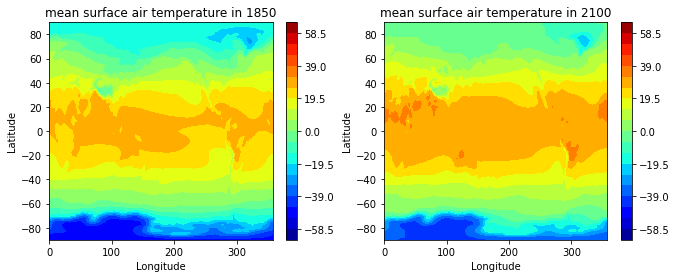

In [4]:
#.............................................
# DATA MANIPULATION AND SANITY PLOT
#.............................................

LON, LAT = np.meshgrid(lon, lat)

plt.figure(figsize=(11,4))

plt.subplot(1,2,1)
cs = plt.contourf(LON, LAT, tas[79,0,:,:], cmap ="jet",levels = np.linspace(-65,65,21))  
cbar = plt.colorbar(cs)   
plt.title('mean surface air temperature in ' + str(np.round(year[0],0))[:4]) 
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('tight')
#plt.legend()

plt.subplot(1,2,2)
cs = plt.contourf(LON, LAT, tas[79,-1,:,:], cmap ="jet",levels = np.linspace(-65,65,21))  
cbar = plt.colorbar(cs)   
plt.title('mean surface air temperature in ' + str(np.round(year[-1],0))[:4]) 
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('tight')
#plt.legend()
plt.show()

In [5]:
#...........................................
# Calculating GMT for each year and member
#...........................................

cosl=np.cos(np.pi*lat/180) #cos(lat) as a vector 
cosll=np.tile(cosl,(1,1,1,1))
coslat=np.tile(cosll,(80,251,144,1)) #replicate vector
coslat=np.swapaxes(coslat,-1,-2) #matrix of cos(lat)

y_synth=np.sum(np.multiply(tas,coslat),axis=(2,3))/np.sum(coslat,axis=(2,3))

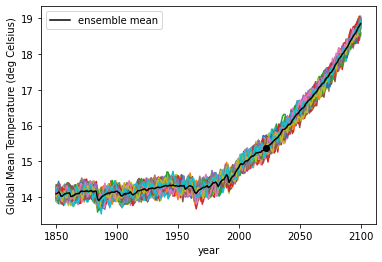

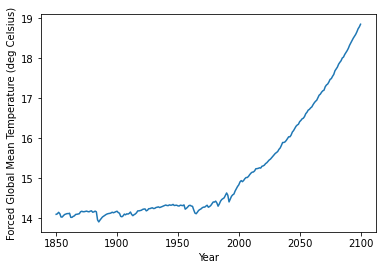

In [6]:
#.......................................
#   SANITY PLOT
#.......................................

forced_temp=np.mean(y_synth[0:70,:],axis=0)

for i in np.arange(0,70,1):
 plt.plot(year, y_synth[i,:])#,label='member #' + str(i+1))

plt.plot(year, forced_temp,'k',label='ensemble mean')
plt.plot(2022, forced_temp[172],'ko')
plt.xlabel('year')
plt.ylabel('Global Mean Temperature (deg Celsius)')
plt.axis('tight')
plt.legend()
plt.show()


plt.plot(year, forced_temp,)
plt.xlabel('Year')
plt.ylabel('Forced Global Mean Temperature (deg Celsius)')
plt.axis('tight')
#plt.legend()
plt.show()

In [7]:
#.............................................
# PREPARE THE DATA FOR TRAINING
#.............................................

# Rename the array to X (inputs) and Y (labels) to stick with machine learning convention
# Separate the X and Y matrices into training and validation sub-sets and reshape

#tas=(tas-np.mean(tas, axis=(0,1)))/np.std(tas, axis=(0,1)) #uncomment if you want to normalize the data

X_train=tas[0:70,:,:,:] # first 70 members
X_val=tas[70:80,:,:,:] # 10 last members
Y_train=np.tile(forced_temp,(70))
Y_val=np.tile(forced_temp,(10))

X_train=X_train.reshape(X_train.shape[0]*X_train.shape[1],X_train.shape[2]*X_train.shape[3])
X_val=X_val.reshape(X_val.shape[0]*X_val.shape[1],X_val.shape[2]*X_val.shape[3])


# Calculate the number of inputs into the neural network (this will be helpful for the next code cell)
# This value is the number of latitudes times the number of longitudes
number_inputs = X_train.shape[-1]

In [8]:
#.............................................
# BUILD THE NEURAL NETWORK
#.............................................

#Define the learning rate of the neural network
learning_rate = 0.0001


# Now we will define the structure of the neural network
model = tf.keras.models.Sequential([ \

          tf.keras.layers.Dropout(.3,input_shape=(int(number_inputs),)),

          tf.keras.layers.Dense(8, activation='relu', use_bias=True, 
            kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.005), 
            bias_initializer='he_normal',
            ),

          tf.keras.layers.Dense(5, activation='relu', use_bias=True,
            kernel_initializer='he_normal', bias_initializer='he_normal', 
            ),

          tf.keras.layers.Dense(1, activation='linear', use_bias=False, 
            kernel_initializer='he_normal', 
            )                                                  
                            
                            ])   

#We will use the stochastic gradient descent (adam) optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
              loss = 'mean_squared_error', #Our loss function is based on mean squared error
              metrics=[tf.keras.metrics.mean_absolute_error], #We will print out the mean absolute error as the network is trained
              )

model.summary()  

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 10512)             0         
_________________________________________________________________
dense (Dense)                (None, 8)                 84104     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 45        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 84,154
Trainable params: 84,154
Non-trainable params: 0
_________________________________________________________________


In [9]:
#.............................................
# UNCOMMENT TO RETRAIN THE NEURAL NETWORK
#.............................................

#batch_size = 32 #The number of samples the network sees before it backpropagates (batch size)
#epochs =  100 #The number of times the network will loop through the entire dataset (epochs)
#shuffle = True #Set whether to shuffle the training data so the model doesn't see it sequentially 
#verbose = 2 #Set whether the model will output information when trained (0 = no output; 2 = output accuracy every epoch)

###Train the neural network!
#model.fit(X_train, Y_train, validation_data=(X_val, Y_val), 
#          batch_size=batch_size, epochs=epochs, shuffle=shuffle, verbose=verbose)

In [10]:
#.............................................
# LOAD ALREADY TRAINED MODEL
#.............................................

# load model, including its weights and the optimizer
model = tf.keras.models.load_model('my_model_Forced_Temp.h5')
# Show the model architecture
model.summary()
# loss and accuracy in "new model"
loss, acc = model.evaluate(X_val, Y_val, verbose=2)
print('Restored model, MSE: ', loss)
print('Restored model, MAE: ', acc)


2022-06-21 15:06:53.894955: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-21 15:06:53.895661: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_1 (Dropout)          (None, 10512)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 84104     
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 45        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 84,154
Trainable params: 84,154
Non-trainable params: 0
_________________________________________________________________
2510/2510 - 0s - loss: 0.0125 - mean_absolute_error: 0.0679
Restored model, MSE:  0.012511386107876006
Restored model, MAE:  0.06785249


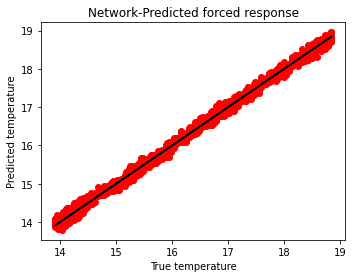

In [11]:
#.............................................
# Network Predictions 
#.............................................

#Make the prediction from the model 
predictions = model.predict(X_val)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(Y_val, predictions,'ro')
plt.plot(forced_temp, forced_temp ,'k')
plt.xlabel('True temperature')
plt.ylabel('Predicted temperature')
plt.title('Network-Predicted forced response') 
plt.axis('tight')


plt.show()



In [25]:
#.............................................
# GET EXPLANATIONS FROM SHAP
#.............................................

# select a set of background examples to take an expectation over
#background = X_train[np.random.choice(X_train.shape[0], 1000, replace=False)]
background1 = X_val[0][np.newaxis,...]*0
background2 = np.mean(X_val[9*251+0:9*251+31],axis=0)[np.newaxis,...] # or background2 = X_val[9*251+0:9*251+31]
background3 = X_val[9*251+175][np.newaxis,...]
background4 = np.mean(X_val[9*251+220:10*251],axis=0)[np.newaxis,...]


# explain predictions of the model on three images
e1 = shap.DeepExplainer(model, background1)
e2 = shap.DeepExplainer(model, background2)
e3 = shap.DeepExplainer(model, background3)
e4 = shap.DeepExplainer(model, background4)
# ...or pass tensors directly
#e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)

the true Forced Temp in 2022 is 15.364259901485005
the NN prediction is [[15.364097]]


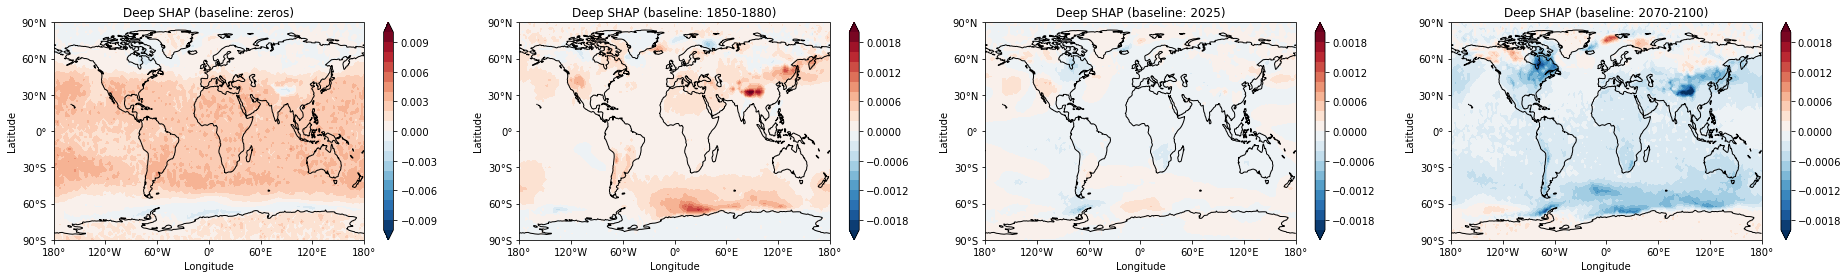

In [27]:
target_year=2022 #target year to be explained

t=target_year-1850
sample=tas[79,t,:,:] #temperature map of the target year from the "validation" member

# model prediction
sample_prediction = model.predict(sample.reshape((1,number_inputs)))

print('the true Forced Temp in ' + str(target_year) + ' is ' +str(forced_temp[t]))
print('the NN prediction is ' +str(sample_prediction))


shap_values1 = e1.shap_values(sample.reshape((1,number_inputs)))
shap_values2 = e2.shap_values(sample.reshape((1,number_inputs)))
shap_values3 = e3.shap_values(sample.reshape((1,number_inputs)))
shap_values4 = e4.shap_values(sample.reshape((1,number_inputs)))

shap_values11 = np.array(shap_values1)[0,0,:].reshape(lat.shape[0],lon.shape[0])
shap_values22 = np.array(shap_values2)[0,0,:].reshape(lat.shape[0],lon.shape[0])
shap_values33 = np.array(shap_values3)[0,0,:].reshape(lat.shape[0],lon.shape[0])
shap_values44 = np.array(shap_values4)[0,0,:].reshape(lat.shape[0],lon.shape[0])



#PLOTTING

plt.figure(figsize=(32,4))
ax=plt.subplot(1,4,1,projection=ccrs.PlateCarree())
samplep,lonp = add_cyclic_point(shap_values11, coord=lon)
cs = plt.contourf(lonp, lat, samplep, cmap ="RdBu_r",levels = np.linspace(-0.01,0.01,21),extend = 'both')  
cbar = plt.colorbar(cs)   
plt.title('Deep SHAP (baseline: zeros)') 
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('tight')
ax.coastlines()
#plt.legend()
# Define the xticks for longitude
ax.set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
# Define the yticks for latitude
ax.set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)


ax=plt.subplot(1,4,2,projection=ccrs.PlateCarree())
samplep,lonp = add_cyclic_point(shap_values22, coord=lon)
cs = plt.contourf(lonp, lat, samplep, cmap ="RdBu_r",levels = np.linspace(-0.002,0.002,21),extend = 'both')  
cbar = plt.colorbar(cs)   
plt.title('Deep SHAP (baseline: 1850-1880)') 
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('tight')
ax.coastlines()
#plt.legend()
# Define the xticks for longitude
ax.set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
# Define the yticks for latitude
ax.set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)


ax=plt.subplot(1,4,3,projection=ccrs.PlateCarree())
samplep,lonp = add_cyclic_point(shap_values33, coord=lon)
cs = plt.contourf(lonp, lat, samplep, cmap ="RdBu_r",levels = np.linspace(-0.002,0.002,21),extend = 'both')  
cbar = plt.colorbar(cs)   
plt.title('Deep SHAP (baseline: 2025)') 
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('tight')
ax.coastlines()
#plt.legend()
# Define the xticks for longitude
ax.set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
# Define the yticks for latitude
ax.set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)


ax=plt.subplot(1,4,4,projection=ccrs.PlateCarree())
samplep,lonp = add_cyclic_point(shap_values44, coord=lon)
cs = plt.contourf(lonp, lat, samplep, cmap ="RdBu_r",levels = np.linspace(-0.002,0.002,21),extend = 'both')  
cbar = plt.colorbar(cs)   
plt.title('Deep SHAP (baseline: 2070-2100)') 
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('tight')
ax.coastlines()
#plt.legend()
# Define the xticks for longitude
ax.set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
# Define the yticks for latitude
ax.set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

plt.show()